## Experimenting with mini-batches
In this notebook, we show how to use different `mini_batch_size` at training and how does this affect the training.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
import logging
# logging.basicConfig(level=logging.DEBUG) # Enable this if you want extra debug info

np.random.seed(1)
sys.path.append(os.path.abspath('..'))

### Prepare Dataset
The dataset was taken from online course [Neural Networks by Andrew Ng](https://www.coursera.org/learn/neural-networks-deep-learning/). It consist of images that may contain cats. Each image is labeled with `Y=1` if it contains a cats or `Y=0` if it does not. 

In [2]:
from cats import load_dataset
from mynn.preprocess import StandardScaler
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_dataset()

# Reshape, to be in the (Nx, m) format where axis=0 is all pixels in flatten.
train_set_x_orig = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_orig = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# Normalize input by centering and dividing with variance
std_scaler = StandardScaler()
std_scaler.train(train_set_x_orig)

train_X = std_scaler.scale(train_set_x_orig)
train_Y = train_set_y_orig
test_X = std_scaler.scale(test_set_x_orig)
test_Y = test_set_y_orig
print(f"Training set of {train_X.shape[1]} samples")
print(f"Test set of {test_X.shape[1]} samples")

Training set of 209 samples
Test set of 50 samples


### Create a 3-Layers FNN
We will use 3 hidden layer with `relu` activation function and one `sigmoid` output layer.


In [6]:
from mynn import NNModel
from mynn.activation import ReLUActivation, SigmoidActivation
from mynn.optimizers import Adam
from mynn.layers import FullyConnected as FC, Input
from mynn.loss import SigmoidCrossEntropyLoss


x_input = Input((train_X.shape[0], None))
x = FC(20, ReLUActivation)(x_input)
x = FC(7, ReLUActivation)(x)
x = FC(5, ReLUActivation)(x)
x = FC(train_Y.shape[0])(x)


### Hyper-parameter optimization on mini-batch-size
We train the same model with different `mini_batch_size` in order to check the learning speed on training dataset as well as on test dataset.

In [11]:
from mynn.regularization import DropoutRegularization, L2Regularization
from mynn.validation import performance_training_callback
from mynn.endecoders import ThresholdBinaryEncoderDecoder

epochs = 800
costs_callback = performance_training_callback([train_X, test_X], [train_Y, test_Y], every_nth_iteration=15)
nn_parameters = {
    'inputs': x_input,
    'outputs': x,
#     'regularization': DropoutRegularization(keep_probs=[0.8, 0.8, 0.5, 1]),
    'optimizer': Adam(learning_rate=0.001),
    'loss_function': SigmoidCrossEntropyLoss(),
    'output_encoder_decoder': ThresholdBinaryEncoderDecoder()
}
training_scenarios =[
    ('Batch-mode', {'mini_batch_size': None } ),
    ('mini-batch-128', {'mini_batch_size': 128 } ),
    ('mini-batch-64', {'mini_batch_size': 64 } )
]

configuration_model = {}
configuration_ctx = {}
for name, training_params in training_scenarios:
    model = NNModel(**nn_parameters)
    configuration_model[name] = model
    configuration_ctx[name] = model.train(train_X, train_Y,
                                         epochs=epochs, post_iteration_callbacks=[costs_callback],
                                         **training_params)


/Users/konstantinos/Workspace/mynn/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/konstantinos/Workspace/mynn/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Compare and examine performance per configuration
In the following graphs we will compare the training speed per different `mini_batch_size` as also the final prediction performance on `dev` set.

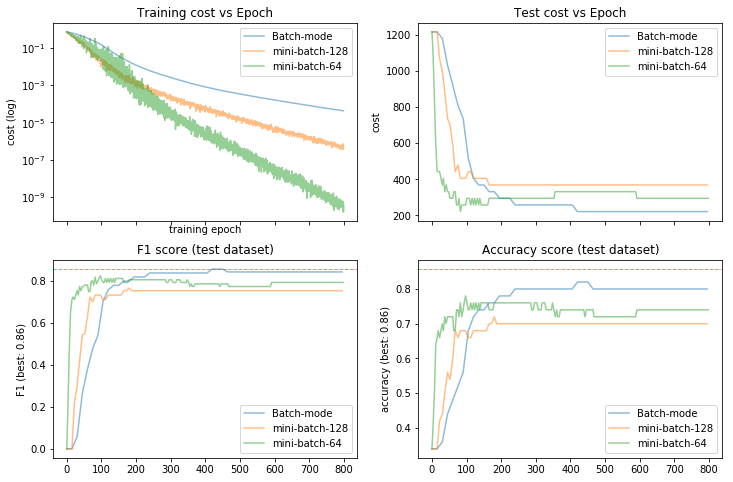

In [41]:
f, axarr = plt.subplots(2, 2, sharex=True, figsize=(12, 8))
for name, ctx in configuration_ctx.items():
    df = ctx.iterations_history_as_dataframe()
    axarr[0][0].plot(df['epoch'], df['loss'],  alpha=0.5)
axarr[0][0].legend(list(map(lambda x: x[0], training_scenarios)))
axarr[0][0].set_title('Training cost vs Epoch')
axarr[0][0].set_xlabel('training epoch')
axarr[0][0].set_yscale('log')
axarr[0][0].set_ylabel('cost (log)')

for name, ctx in configuration_ctx.items():
    df = ctx.iterations_history_as_dataframe().dropna()
    axarr[0][1].plot(df['epoch'], df['cross_entropy_1'],  alpha=0.5)
axarr[0][1].legend(list(map(lambda x: x[0], training_scenarios)))
axarr[0][1].set_title('Test cost vs Epoch')
axarr[0][1].set_ylabel('cost')

f1_max = 0
for name, ctx in configuration_ctx.items():
    df = ctx.iterations_history_as_dataframe().dropna()
    f1_max = max(np.max(df['f1_1']), f1_max)
    axarr[1][0].plot(df['epoch'], df['f1_1'],  alpha=0.5)
axarr[1][0].legend(list(map(lambda x: x[0], training_scenarios)))
axarr[1][0].set_title('F1 score (test dataset)')
axarr[1][0].set_ylabel(f'F1 (best: {f1_max:0.2f})')
axarr[1][0].axhline(f1_max, linewidth=0.5, linestyle='-.', color='red')

accuracy_max = 0
for name, ctx in configuration_ctx.items():
    df = ctx.iterations_history_as_dataframe().dropna()
    accuracy_max = max(np.max(df['accuracy_1']), f1_max)
    axarr[1][1].plot(df['epoch'], df['accuracy_1'], alpha=0.5)
axarr[1][1].legend(list(map(lambda x: x[0], training_scenarios)))
axarr[1][1].set_title('Accuracy score (test dataset)')
axarr[1][1].set_ylabel(f'accuracy (best: {accuracy_max:0.2f})')
axarr[1][1].axhline(np.max(accuracy_max), linewidth=0.5, linestyle='-.', color='red')

### Conclusions
From the above graphs it is clear that test performance is stalled above `600` epochs and it looks that arround `400` epochs the model starts overfitting and the performance on test dataset slightly drops (we are using regularization and it is not expeted to drop that much). Training with `mini_batch_size=64` although not stable had always better perfromance than the rest of training methods and it learn faster with best performance at around ~80 epochs.